<a href="https://colab.research.google.com/github/WizardOfPitty/Computational-Methods-in-Physics/blob/main/Intro_to_Random_Forest/0_2_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Intro_to_Random_Forest/0_2_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Random Forest for Classifying Exoplanets

Author: Fatemeh (Fatima) Bagheri

Date Created: November 24, 2022, Last Modified: December 19, 2022

Notebook 2/2 of the DSECOP Module: An Introduction to the Random Forest algorithm.


We want to classify exoplanets based on their types. There are two major types of exoplanets: Rocky planets and Jovian (Jupiter-like) planets. Rocky planets are similar to Earth; they are made of rocks, not massive, and located at a distance smaller than the *snow-line* ([https://en.wikipedia.org/wiki/Frost_line_(astrophysics)]) of their host stars. On the other hand, Jovian planets are massive, gaseous planets that could be found at any distance, so close to the host star (hot-Jupiters) or further away, like Jupiter in our solar system.

Basically, our problem is a classification problem; if the exoplanet is a rocky planet, we label it with 0; if it's a Jovian but not Hot-Jupiter, its label is 1, and Hot_Jupiters' labels are 2. We implement a classification model with a `Random Forest classifier` in this lecture using Python's `Scikit-Learn`.

The steps in this procedure are:

* importing necessary libraries,
* reading the data,
* splitting the data into training and test sets,
* defining hyperparameters (for more information, look at the Introduction to Deep Learning module) of the model and training a Random Forest Classifier model,
* and last, evaluating the model.

So, let's start! First, import some needed libraries,


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files

In [3]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving RandomForest_data.csv to RandomForest_data.csv
Saving RandomForestData_header.txt to RandomForestData_header.txt
User uploaded file "RandomForest_data.csv" with length 1455260 bytes
User uploaded file "RandomForestData_header.txt" with length 5306 bytes


Now, read the data, and you can also explore their parameters and simple statistics.



In [4]:
dataset = pd.read_csv("RandomForest_data.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 94 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1445 non-null   int64  
 1   pl_name          1445 non-null   object 
 2   hostname         1445 non-null   object 
 3   default_flag     1445 non-null   int64  
 4   sy_snum          1445 non-null   int64  
 5   sy_pnum          1445 non-null   int64  
 6   discoverymethod  1445 non-null   object 
 7   disc_year        1445 non-null   int64  
 8   disc_facility    1445 non-null   object 
 9   soltype          1445 non-null   object 
 10  pl_controv_flag  1445 non-null   int64  
 11  pl_refname       1445 non-null   object 
 12  pl_orbper        1445 non-null   float64
 13  pl_orbpererr1    1393 non-null   float64
 14  pl_orbpererr2    1393 non-null   float64
 15  pl_orbperlim     1445 non-null   float64
 16  pl_orbsmax       1400 non-null   float64
 17  pl_orbsmaxerr1

or

In [5]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1445.0,17910.112803,14649.468213,102.000000,1356.000000,23847.000000,32281.000000,33316.000000
default_flag,1445.0,0.582699,0.493284,0.000000,0.000000,1.000000,1.000000,1.000000
sy_snum,1445.0,1.237370,0.482076,1.000000,1.000000,1.000000,1.000000,4.000000
sy_pnum,1445.0,1.339100,0.913063,1.000000,1.000000,1.000000,1.000000,6.000000
disc_year,1445.0,2014.520415,5.004890,1999.000000,2010.000000,2016.000000,2019.000000,2022.000000
...,...,...,...,...,...,...,...,...
sy_kmagerr2,1427.0,-0.024894,0.019654,-0.304000,-0.025000,-0.022000,-0.020000,-0.011000
sy_gaiamag,1440.0,11.871626,1.946051,5.240200,10.740900,11.953700,13.027600,19.879000
sy_gaiamagerr1,1440.0,0.000478,0.000449,0.000135,0.000268,0.000366,0.000533,0.008487
sy_gaiamagerr2,1440.0,-0.000478,0.000449,-0.008487,-0.000533,-0.000366,-0.000268,-0.000135


We only need some of the information in the data file to classify the exoplanets based on their types. Therefore, we should work just with the parameters that could be related to the exoplanets types:  

In [7]:
# read file: NASAExoplanet_header.txt to understand the header of the data
f = open('RandomForestData_header.txt', 'r')
lines = f.readlines()
# create empty header list
header = {}
for i, l in enumerate(lines):
    #lookes into lines and splits based on tab separation
    parts = l.split('\t')
    #Integrates the parts object into the header list
    header[parts[2].rstrip('\n')] = parts[1].rstrip(' ')

# define the paramters that we need, use the file: NASAExoplanet_header to find which columns of data you need
parameters = ['Planet Mass or Mass*sin(i) [Earth Mass]',
              'Stellar Metallicity [dex]', 'Stellar Surface Gravity [log10(cm/s**2)]'
              ,'Stellar Mass [Solar mass]',
              'Equilibrium Temperature [K]', 'Stellar Effective Temperature [K]',
              'Orbital Period [days]', 'Stellar Radius [Solar Radius]','label']


# store needed data
data = pd.DataFrame()
for p in parameters:
    data[p] = dataset[header[p]].astype('float32')




Now, we define the label of the exoplanets as what we want to predict or outputs (y) and the parameters of the exoplanets as the inputs (x):



In [8]:
y = data['label']
X = data.drop(['label'], axis=1)

In [9]:
#all parameters being used to predict y
print(X.head())
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# the output we want to predict (0 = rocky, 1 = Jovian, 2= hot Jovian)
print(y.head())

   Planet Mass or Mass*sin(i) [Earth Mass]  Stellar Metallicity [dex]  \
0                               327.364899                      -0.30   
1                               327.350006                      -0.30   
2                               743.722229                      -0.03   
3                               740.510010                      -0.03   
4                               291.437988                       0.16   

   Stellar Surface Gravity [log10(cm/s**2)]  Stellar Mass [Solar mass]  \
0                                      4.31                       0.95   
1                                      4.25                       0.95   
2                                      4.26                       1.26   
3                                      4.22                       1.27   
4                                      4.38                       1.08   

   Equilibrium Temperature [K]  Stellar Effective Temperature [K]  \
0                       1915.0                 



Based on this data, we should define our training and test sets by splitting data with the ratio of 80/20, with the help of `Scikit-Learn's train_test_split()`:



In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Now it's time to import the `RandomForestClassifier` class and create the model. As mentioned earlier, we should set a few hyperparameters to define our model. One is the number of decision trees in our random forest model; the other is the depth of each decision tree. Thus, let's create a model with 5 decision trees (`n_estimators=5`) with a depth of 3 (`max_depth=3`):


In [11]:
from sklearn.ensemble import RandomForestClassifier

our_model = RandomForestClassifier(n_estimators=5, max_depth=3, random_state=42)

Our model should learn the relationship between the parameters in X and labels in y from the training set. To do this, we can **fit** the model with training set by calling `fit()`:


In [12]:
our_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=5, random_state=42)

To see what exactly is happening in our model, we can look at the structure of decision trees. By calling the `tree module` from `cikit-Learn`, we can visualize the trees:
This can be done by using the tree module built into `Scikit-Learn`, and then looping through each of the estimators in the ensemble:

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1608637542)


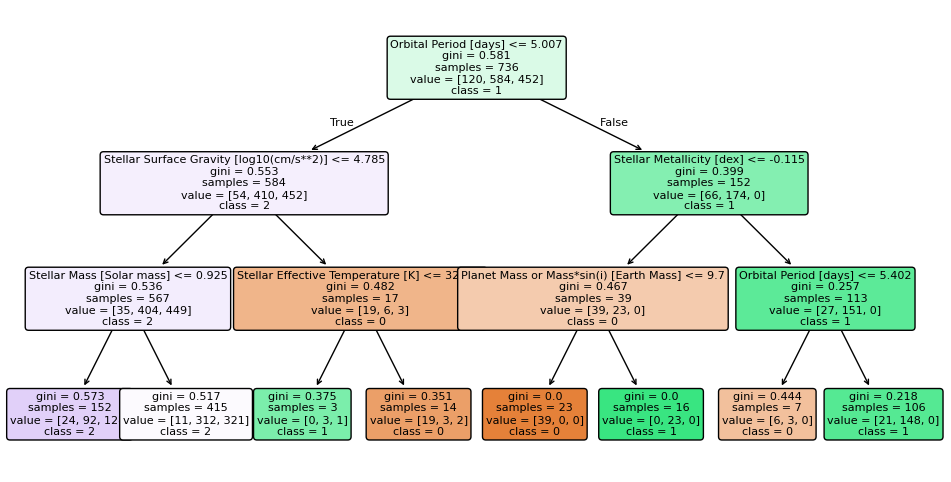

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1273642419)


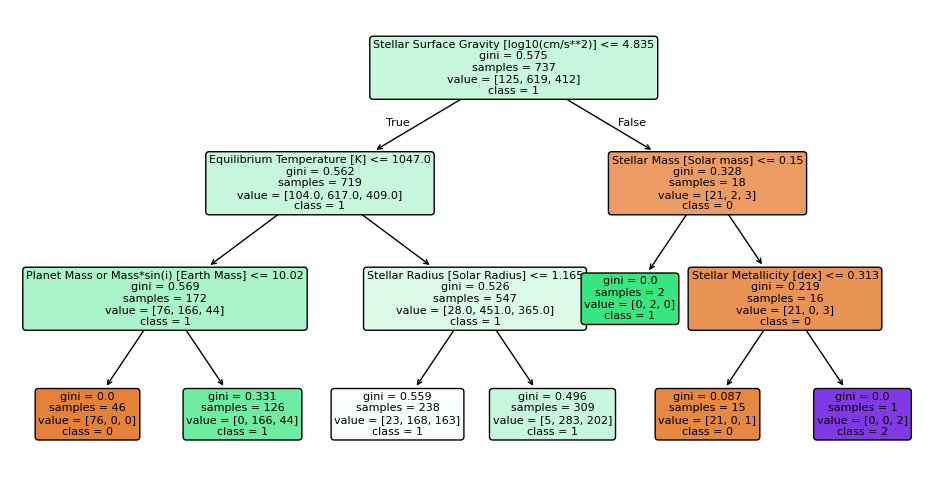

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1935803228)


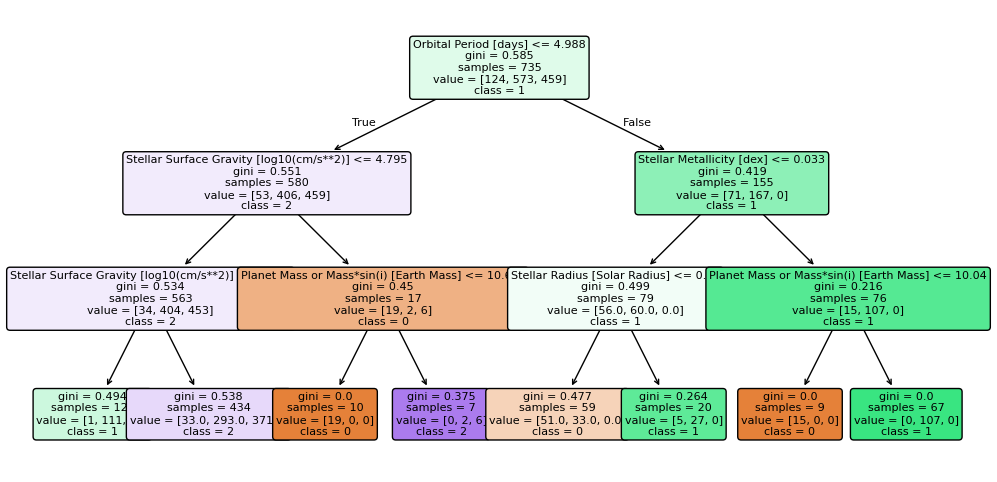

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=787846414)


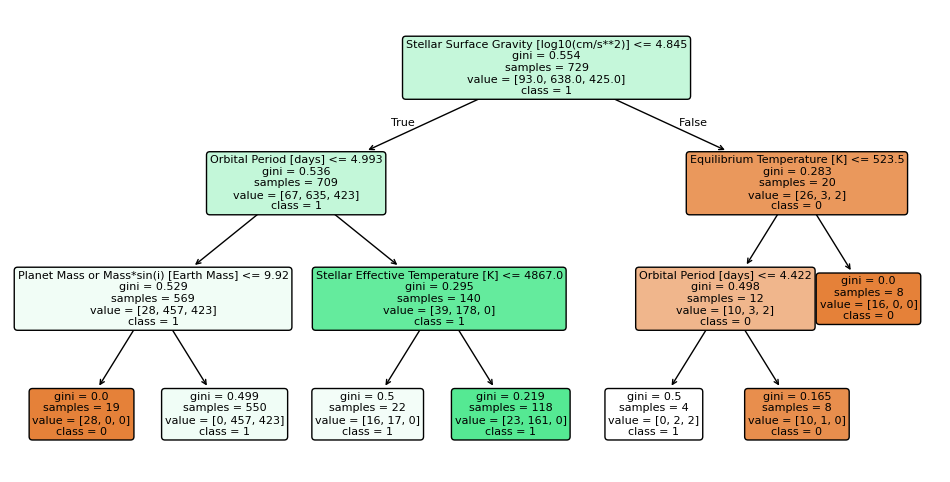

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=996406378)


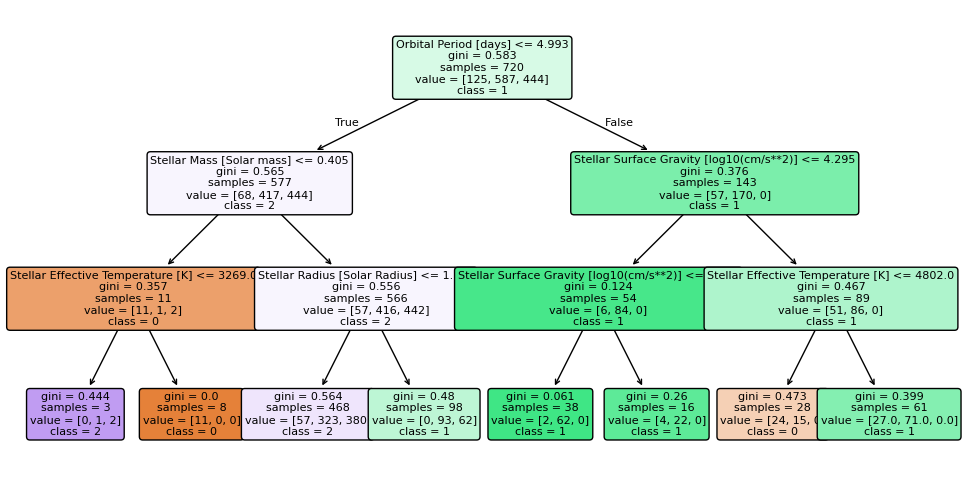

In [13]:
from sklearn import tree

features = X.columns.values                     # The name of each column
classes = ['0', '1', '2']                            # Labels

for estimator in our_model.estimators_:
    print(estimator)
    plt.figure(figsize=(12,6))
    tree.plot_tree(estimator, feature_names=features, class_names=classes, fontsize=8, filled=True, rounded=True)
    plt.show()

We can now use our trained model to the predict the label of the test set:

In [14]:
y_predicted = our_model.predict(X_test)


At this point, we can evaluate the performance of our model. There are several ways to do that. For instance, we can calculate the **accuracy** of the model. The accuracy of the model is the percentage of the number of correct predictions of our model.

The other way is calculating the **confusion matrix**. A confusion matrix is s a specific table layout that allows visualization of the performance of an algorithm. If we want to know the number of **true positive** or **false positive** as well as **true negative** and **false negative**, we can use a confusion matrix. To understand the meaning of the positive/negative true/false concepts, let's define them in our project's context. We labeled the exoplanets in our dataset: if the exoplanet is a rocky planet, we label it with 0, or if it's a Jovian, its label is 1. so, let's say label 1 is positive, and label 0 is negative. Therefore, a positive true means we **correctly** predicted Jupiter-like type (label 1, which is positive) for a sample (or sometimes it's called an *instance* in ML project). The ones predicted as positives but weren't positives are called false positives.

We can now compare the predicted labels against the real labels to evaluate the performance of the model.

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_predicted)
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

         0.0       0.88      0.50      0.64        28
         1.0       0.62      0.72      0.67       155
         2.0       0.47      0.42      0.45       106

    accuracy                           0.59       289
   macro avg       0.66      0.55      0.58       289
weighted avg       0.59      0.59      0.58       289



## Variable Importances

When we use data science methods in scientific research, we often need to learn the physical model behind the problem. In fact, most of the time, that is the reason we use data analyzing methods! Since you do not know the physical model, you want to know the role of each parameter in the analysis. To quantify the relative importance of the parameters in our model, we can use `feature_importances_` in `Skicit-learn` to see the role of a variable in the prediction quantitatively.


In [16]:
importances = list(our_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: Orbital Period [days] Importance: 0.41
Variable: Planet Mass or Mass*sin(i) [Earth Mass] Importance: 0.27
Variable: Stellar Surface Gravity [log10(cm/s**2)] Importance: 0.14
Variable: Stellar Metallicity [dex] Importance: 0.05
Variable: Equilibrium Temperature [K] Importance: 0.04
Variable: Stellar Effective Temperature [K] Importance: 0.04
Variable: Stellar Mass [Solar mass] Importance: 0.03
Variable: Stellar Radius [Solar Radius] Importance: 0.03


## Homework:

Define true negatives and false negatives in the concept of our project.

# Project

Generate a new model with more trees and see how it affects the results. You can remove those variables that have no importance.

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1608637542)


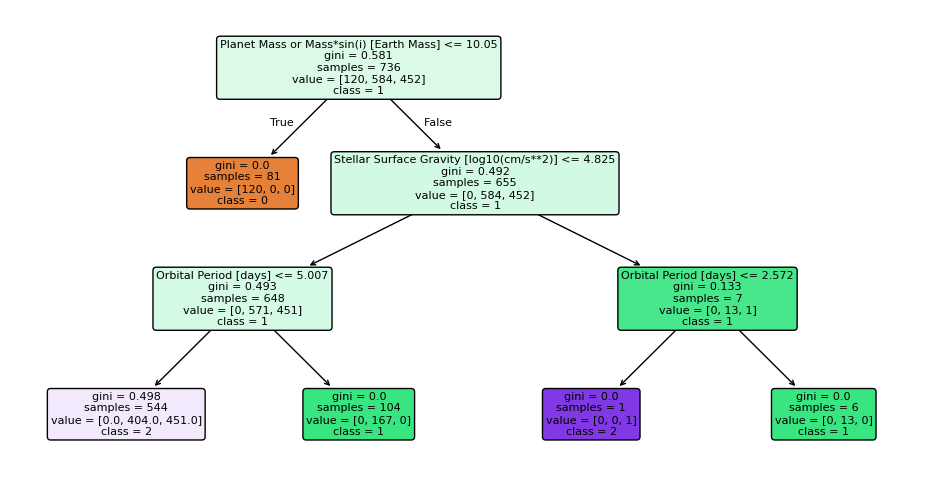

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1273642419)


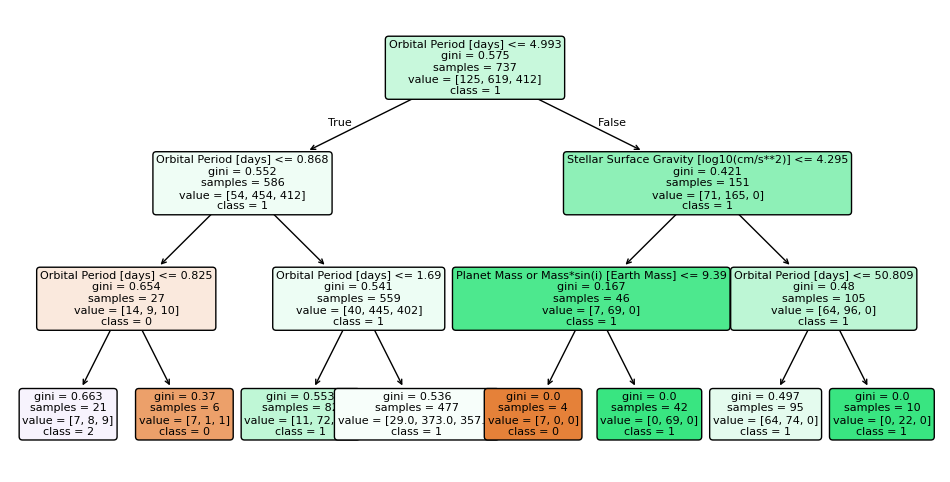

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1935803228)


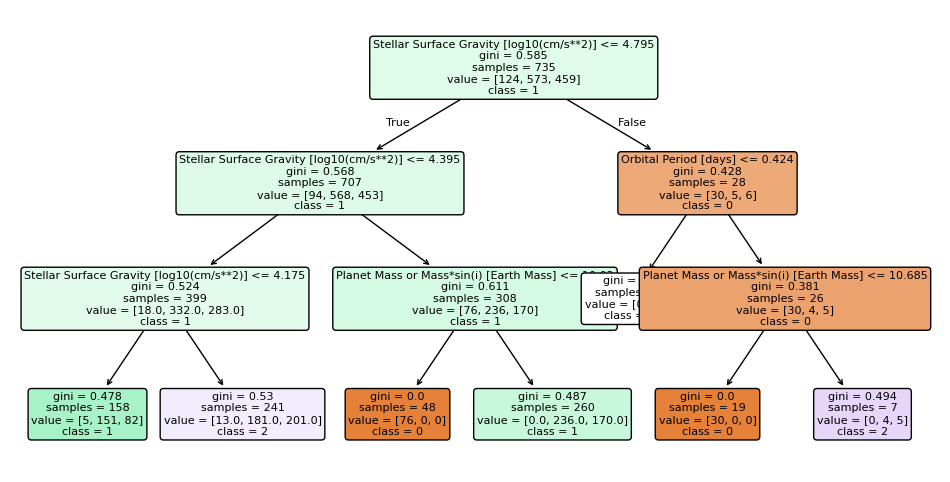

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=787846414)


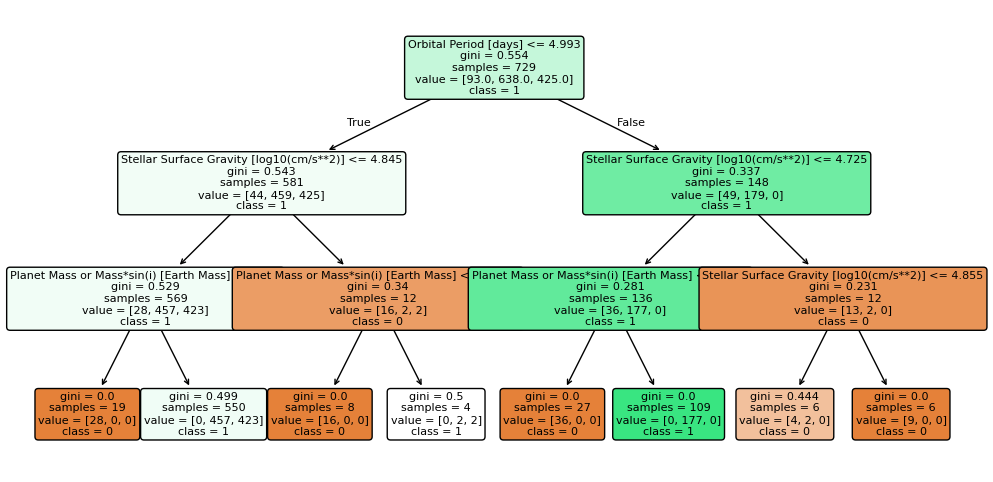

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=996406378)


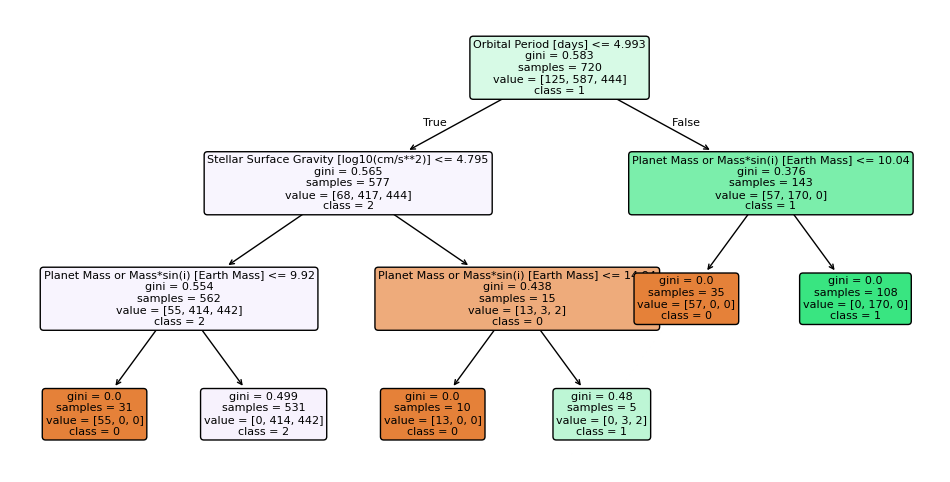

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1201263687)


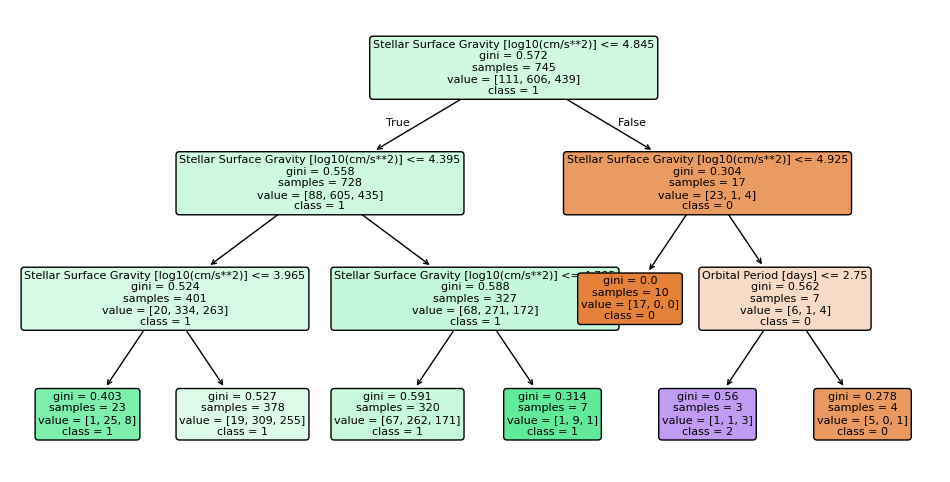

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=423734972)


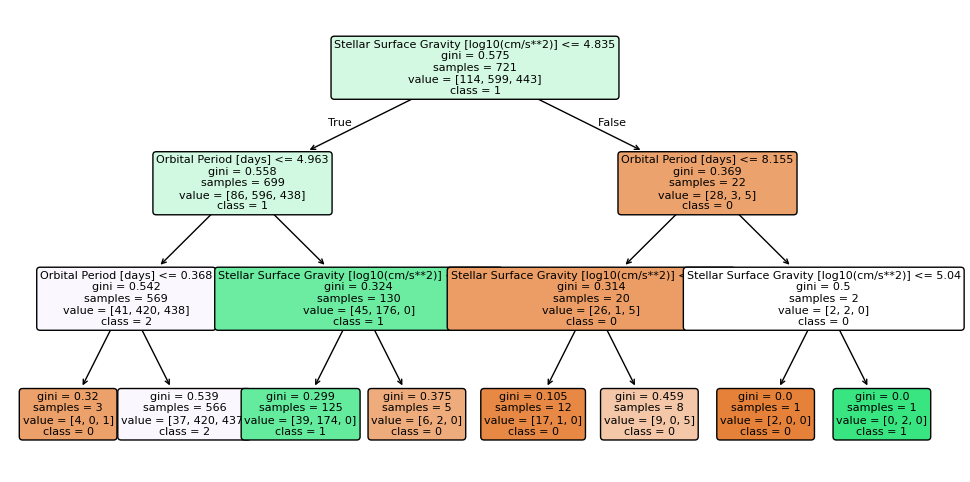

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=415968276)


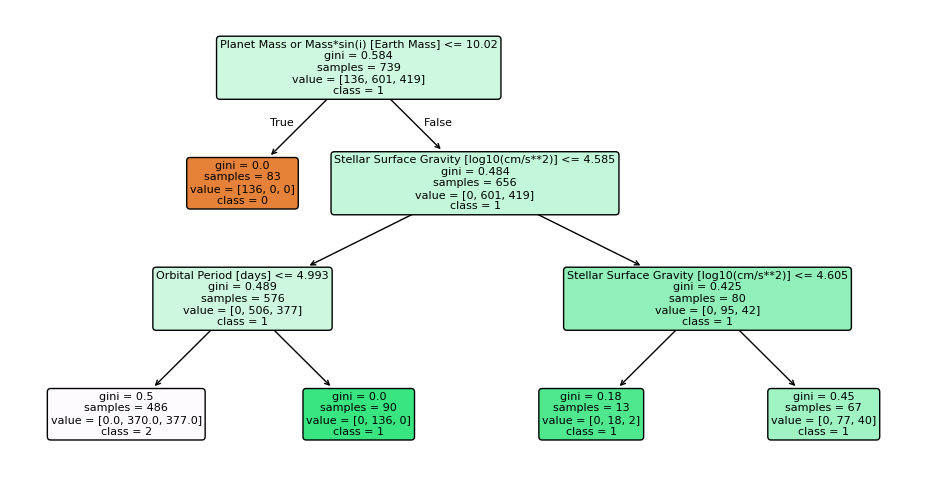

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=670094950)


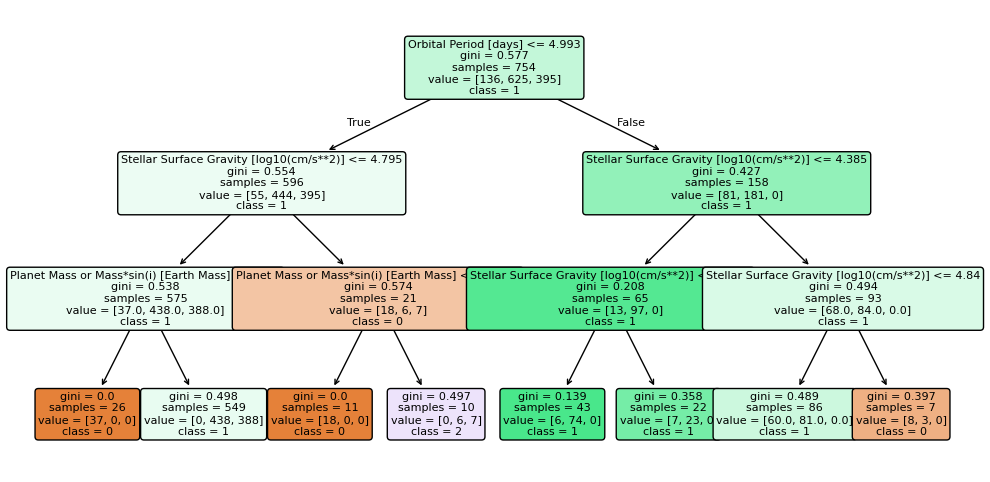

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1914837113)


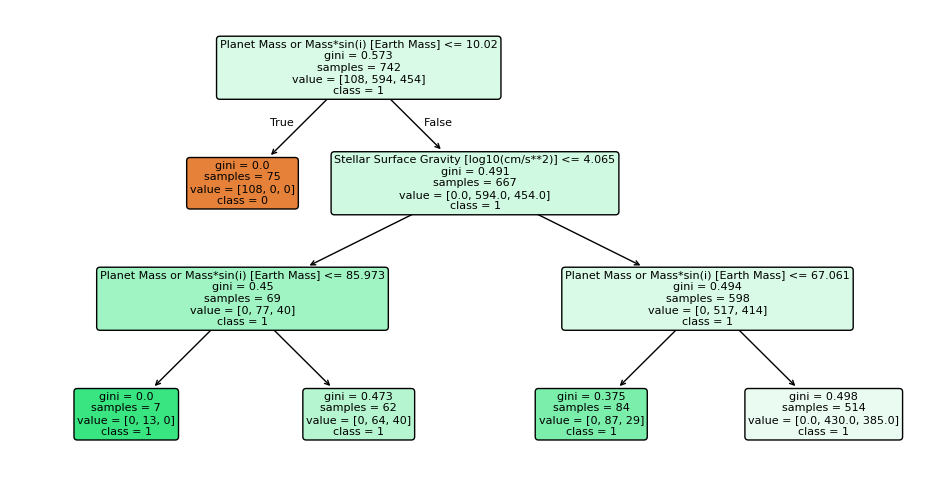

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=669991378)


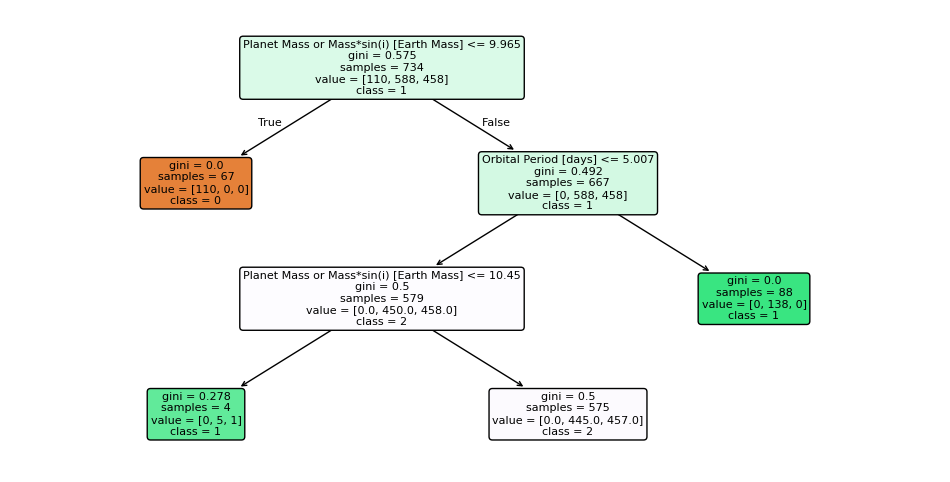

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=429389014)


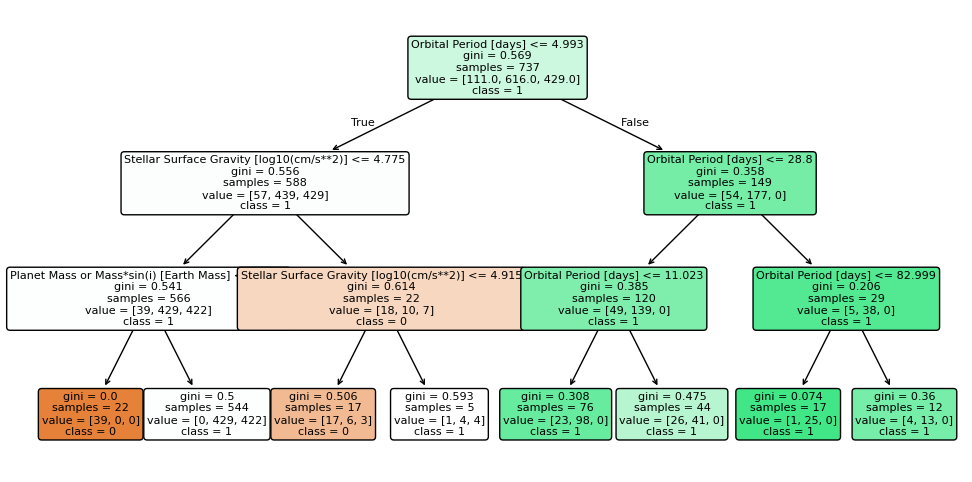

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        28
         1.0       0.59      0.99      0.74       155
         2.0       0.00      0.00      0.00       106

    accuracy                           0.63       289
   macro avg       0.53      0.66      0.58       289
weighted avg       0.41      0.63      0.49       289

Variable: Planet Mass or Mass*sin(i) [Earth Mass] Importance: 0.5
Variable: Orbital Period [days] Importance: 0.32
Variable: Stellar Surface Gravity [log10(cm/s**2)] Importance: 0.18


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_trimmed_1 = X_train.drop(['Stellar Metallicity [dex]', 'Equilibrium Temperature [K]', 'Stellar Effective Temperature [K]', 'Stellar Mass [Solar mass]', 'Stellar Radius [Solar Radius]'],
                               axis=1)

X_test_trimmed_1 = X_test.drop(['Stellar Metallicity [dex]', 'Equilibrium Temperature [K]', 'Stellar Effective Temperature [K]', 'Stellar Mass [Solar mass]', 'Stellar Radius [Solar Radius]'],
                               axis=1)

from sklearn.ensemble import RandomForestClassifier

our_model_1 = RandomForestClassifier(n_estimators=12, max_depth=3, random_state=42)

our_model_1.fit(X_train_trimmed_1, y_train)

from sklearn import tree

features = X_train_trimmed_1.columns.values                     # The name of each column
classes = ['0', '1', '2']                            # Labels

for estimator in our_model_1.estimators_:
    print(estimator)
    plt.figure(figsize=(12,6))
    tree.plot_tree(estimator, feature_names=features, class_names=classes, fontsize=8, filled=True, rounded=True)
    plt.show()

y_predicted_1 = our_model_1.predict(X_test_trimmed_1)

from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_predicted_1)
print(classification_report(y_test,y_predicted_1))

importances = list(our_model_1.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];



DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1608637542)


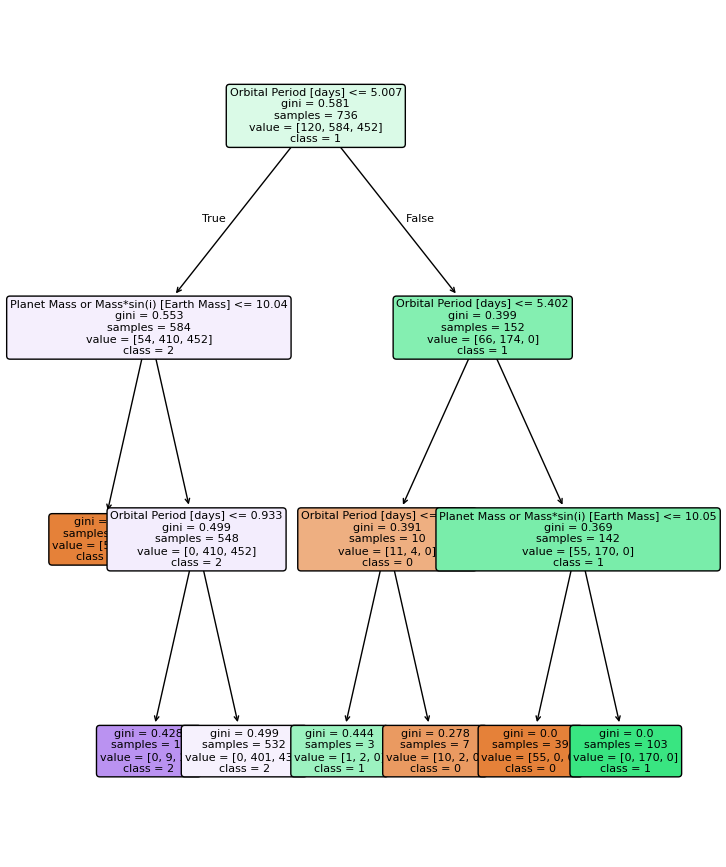

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1273642419)


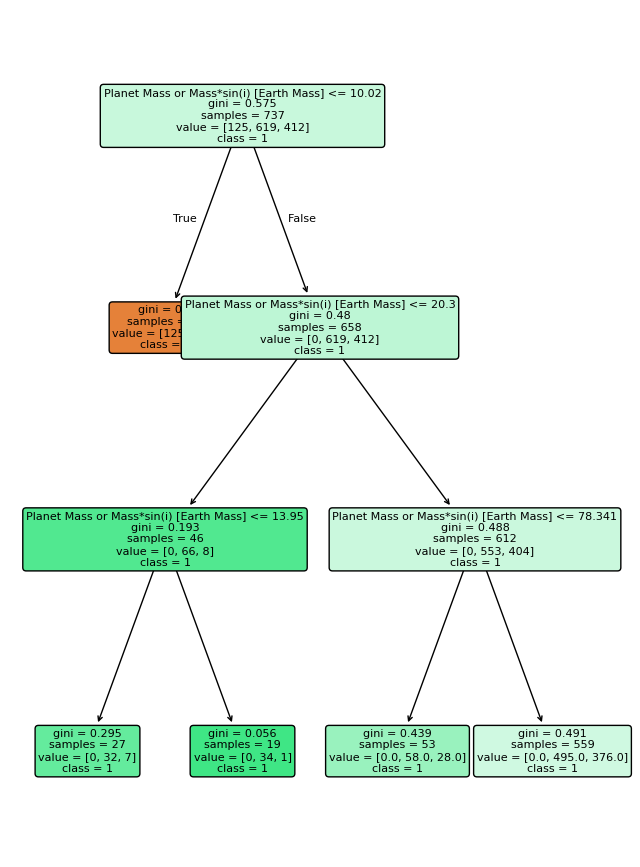

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1935803228)


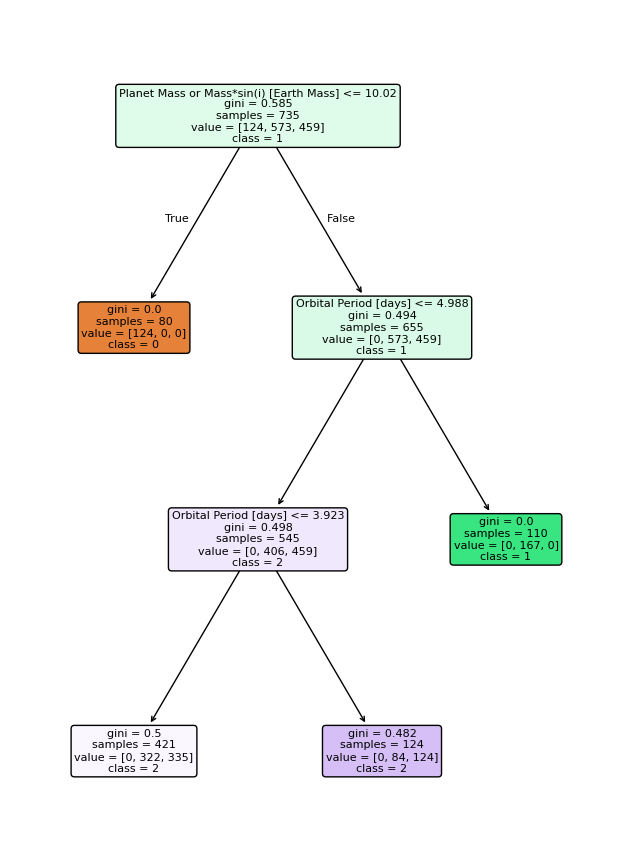

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=787846414)


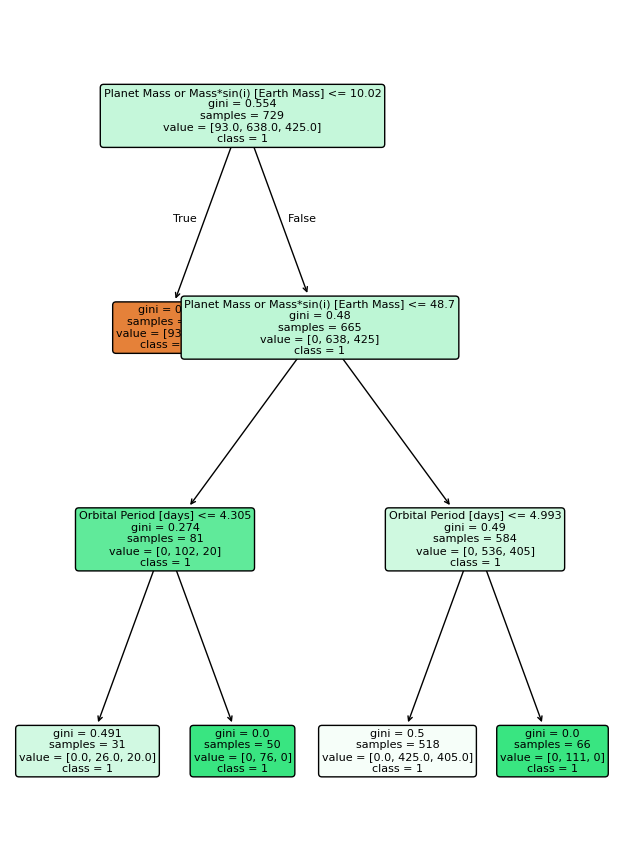

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=996406378)


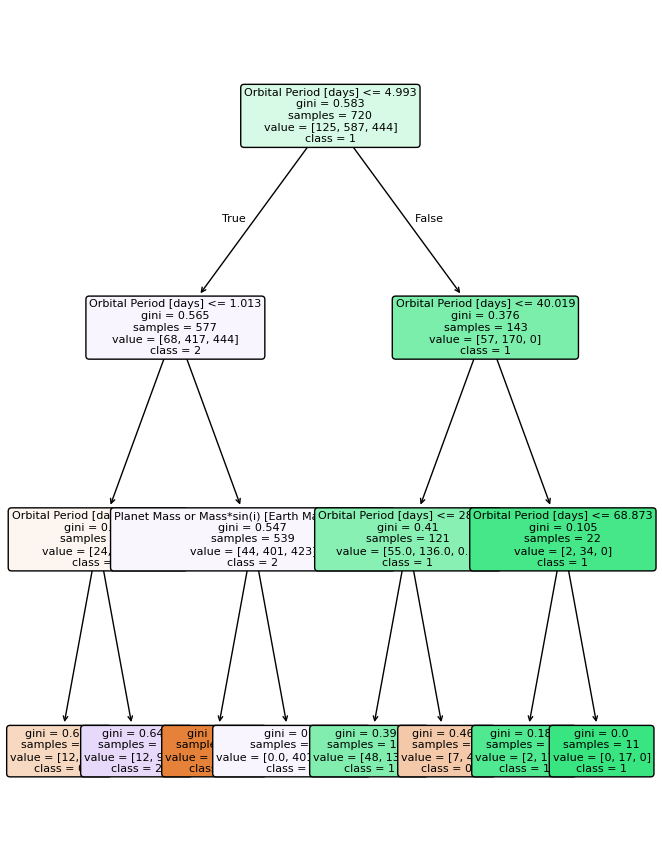

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        28
         1.0       0.61      0.87      0.72       155
         2.0       0.49      0.18      0.26       106

    accuracy                           0.63       289
   macro avg       0.70      0.68      0.66       289
weighted avg       0.60      0.63      0.58       289

Variable: Planet Mass or Mass*sin(i) [Earth Mass] Importance: 0.7
Variable: Orbital Period [days] Importance: 0.3


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_trimmed_2 = X_train.drop(['Stellar Metallicity [dex]', 'Stellar Surface Gravity [log10(cm/s**2)]', 'Equilibrium Temperature [K]', 'Stellar Effective Temperature [K]', 'Stellar Mass [Solar mass]', 'Stellar Radius [Solar Radius]'],
                               axis=1)
X_test_trimmed_2 = X_test.drop(['Stellar Metallicity [dex]', 'Stellar Surface Gravity [log10(cm/s**2)]', 'Equilibrium Temperature [K]', 'Stellar Effective Temperature [K]', 'Stellar Mass [Solar mass]', 'Stellar Radius [Solar Radius]'],
                               axis=1)

from sklearn.ensemble import RandomForestClassifier

our_model_2 = RandomForestClassifier(n_estimators=5, max_depth=3, random_state=42)

our_model_2.fit(X_train_trimmed_2, y_train)

from sklearn import tree

features = X_train_trimmed_2.columns.values                     # The name of each column
classes = ['0', '1', '2']                            # Labels

for estimator in our_model_2.estimators_:
    print(estimator)
    plt.figure(figsize=(8,11))
    tree.plot_tree(estimator, feature_names=features, class_names=classes, fontsize=8, filled=True, rounded=True)
    plt.show()

y_predicted_2 = our_model_2.predict(X_test_trimmed_2)


from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_predicted_2)
print(classification_report(y_test,y_predicted_2))

importances = list(our_model_2.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


